% Author and Title from metadata

- #TODO write some sentence about general motivation for bibliometric analysis

We explore ways to extract information from ICLS and CSCL papers to gain an understanding about the community formed by conference participants and what research is being conducted within the community. After describing how to extract data from the original dataset in suitable format for analysis we perform an exploratory data analysis after which we derive insights into the community using social network analysis and [Nour: NLP etc].

- #TODO write a few centences about the most central findings

## Introduction

Bibliometric study to analyse the papers published in the Proceeding of the Conferences organized by the International Learning Science Society. 
- 

## Data Processing

To extract information from the dataset we first need to convert the data into a suitable format. 
We store the extracted data in csv format, as this makes it accessible to any scientist and can be read as is on the GitHub. Only the data frame containing emails is stored in pickle format, which is done for privacy reasons.

### Metadata


#### Extraction
The provided raw dataset consists of papers in pdf format as well as associated metadata in xml format. This associated metadata consists of : full-length author names, abstract of the paper, associated keywords, document type, publisher, title of the paper, time of issue and the citation string for the paper. 
We extract the xml metadata using the lxmltree python library into a csv file containing the above listed columns. 
The provided xml does not exactly follow the xml standard, hence we handle errors by iteratively parsing the file. 


In [2]:
import os 
import pandas as pd
rootdir = 'data/papers'
contents = []
i = 0
source = []
errors = []
doc = []
year = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                doc.append(path.split('_')[1][:3])
                year.append(int(path.split('/')[-1][6:10]))
                try:
                    text = file.read()
                    if len(text)> 10 :
                        contents.append(text)
                    source.append(subdir[len(rootdir):])
                except:
                    name, message, content = sys.exc_info()
                    errors.append(message)


In [5]:
print('Number of papers is : {}'.format(len(contents)))

Number of papers is : 869


Some of the documents are not readable and have some strange format so we need to take them out of the analysis. Wwe find ourselves with roughly 834 documents 

## Data Cleaning 

your part for the references universities parsing ... 

### Text preprocessing

From the pdf parser some of the documents were corrupted with some weird caracters such as '\xe2\x80\x99s', white space strings ... 

* We used ***beautiful soup*** and ***string*** libraries to only keep the text that we needed without any special character. 

* we applied ***regular expression*** to remove numbers because we thought that numbers were not that important. 

* We put all the words to lower cases 

* We removed the words that were connecting parts of a sentence rather than showing subjects, objects or intent. For us these words were not that important and were only going to increase the bag of words length

* In some methods we used ***Lemmatization*** and ***stemming*** and in other methods we didn't because we wanted to do a mapping with ***GloVe*** vocabulary which we will explain later on. 

***Lemmatization*** is a word variations to the root of the word (e.g. working, works, worked changed to work).
***Stemming*** is the process of reducing inflected and derived words to their word stem, base or root form—generally a written word form
As the use of the stop words to reduce the BOW (bag of words size we also used lemmatization and stemming to be able to reduce the number of words without taking off any information)


***Lemmatization*** and different form of ***Stemming*** were only used with ***TF-IDF*** while doing the Keywords extraction, otherwise we prefered keeping the words as they are because we were doing a mapping with a pretrained stanford word embedding and we did not wand to loose interpretability.  


## Keywords extraction 

For the Keywords extraction we used three methods. 
The first one whe is a trivial one is to search in the pdf itself for keywords and extract them, this method is the most accurate but we found out that for 492 papers we had no keywords included. So we deciced to use two methods for keywords extraction. The first one is ***TF-IDF*** and the second one is ***Rake***.

* ***TF-IDF***:
Tf–idf is one of the most popular term-weighting schemes today, in information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 



With TF-IDF we sorted for each document the words with the highest score and then selected the the 7 first words for each document. 

* ***Rake***: Rake stands for  Rapid Automatic Keyword Extraction. It is an existing python implementation that uses the NLTK toolkit for the score calculations. 

***How it works*** : 
  * It splits the text into sentences and generates some words as candidates.  
  * Various punctuation signs will be treated as sentence boundaries.
  * All words listed in the stopwords file will be treated as phrase boundaries. This helps generate candidates that consist of one or more non-stopwords. However ,it won’t work in cases where the stopword is part of the phrase. For example, ‘new’ is listed in RAKE’s stopword list. This means that neither ‘New York’ nor ‘New Zealand’ can be ever a keyword.
  * For each keyword candidate generated, the algorithm computes the score of the pretended keyword, which is the sum of the scores for each of its words (if it's a composed word). The words are scored according to their frequency and the typical length of a candidate phrase in which they appear.
  * The last step is ranking the scores ansd selecting the ones with the highest score

***Keywords in text***: Select from the text the keywords already given by the authors of the paper. 

Once we have all the keywords from the three methods, we tried to select the most accurate keywords. So we created a method that selects the intersection of TF-IDF keywords and the Rake keywords with the keywords of the authors (if there are any keywords in the text), if the intersection is empty and we have the keywords in the text we only take the keywords of the text. If we don't have any keywords we take the intersection of the TF-IDF and the Rake. If again, the intersection is empty then we only take the TF-IDF keywords because they were closer to the text keywords than the Rake Keywords. 


Once we have our final keywords, we created a method that goes into the metadata and put assign to every document a publication year. 

In [7]:
keywords_df = pd.read_csv('keywords_final.csv')

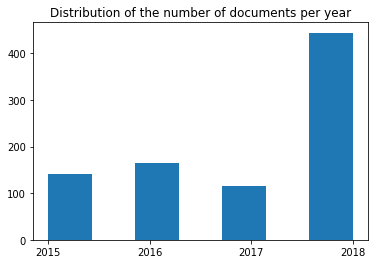

In [30]:
import matplotlib.pyplot as plt
import numpy as np
x = plt.hist(list(keywords_df['year']), bins=7,)
x = plt.xticks(np.arange(min(keywords_df['year']),max(keywords_df['year']+1) , 1))
x = plt.title('Distribution of the number of documents per year')


Since we don't have the same number of documents for each year we needed to scale over the years and use the percentage of appearence of a word. 
So after groupping the words by year and scaling them we found graph below

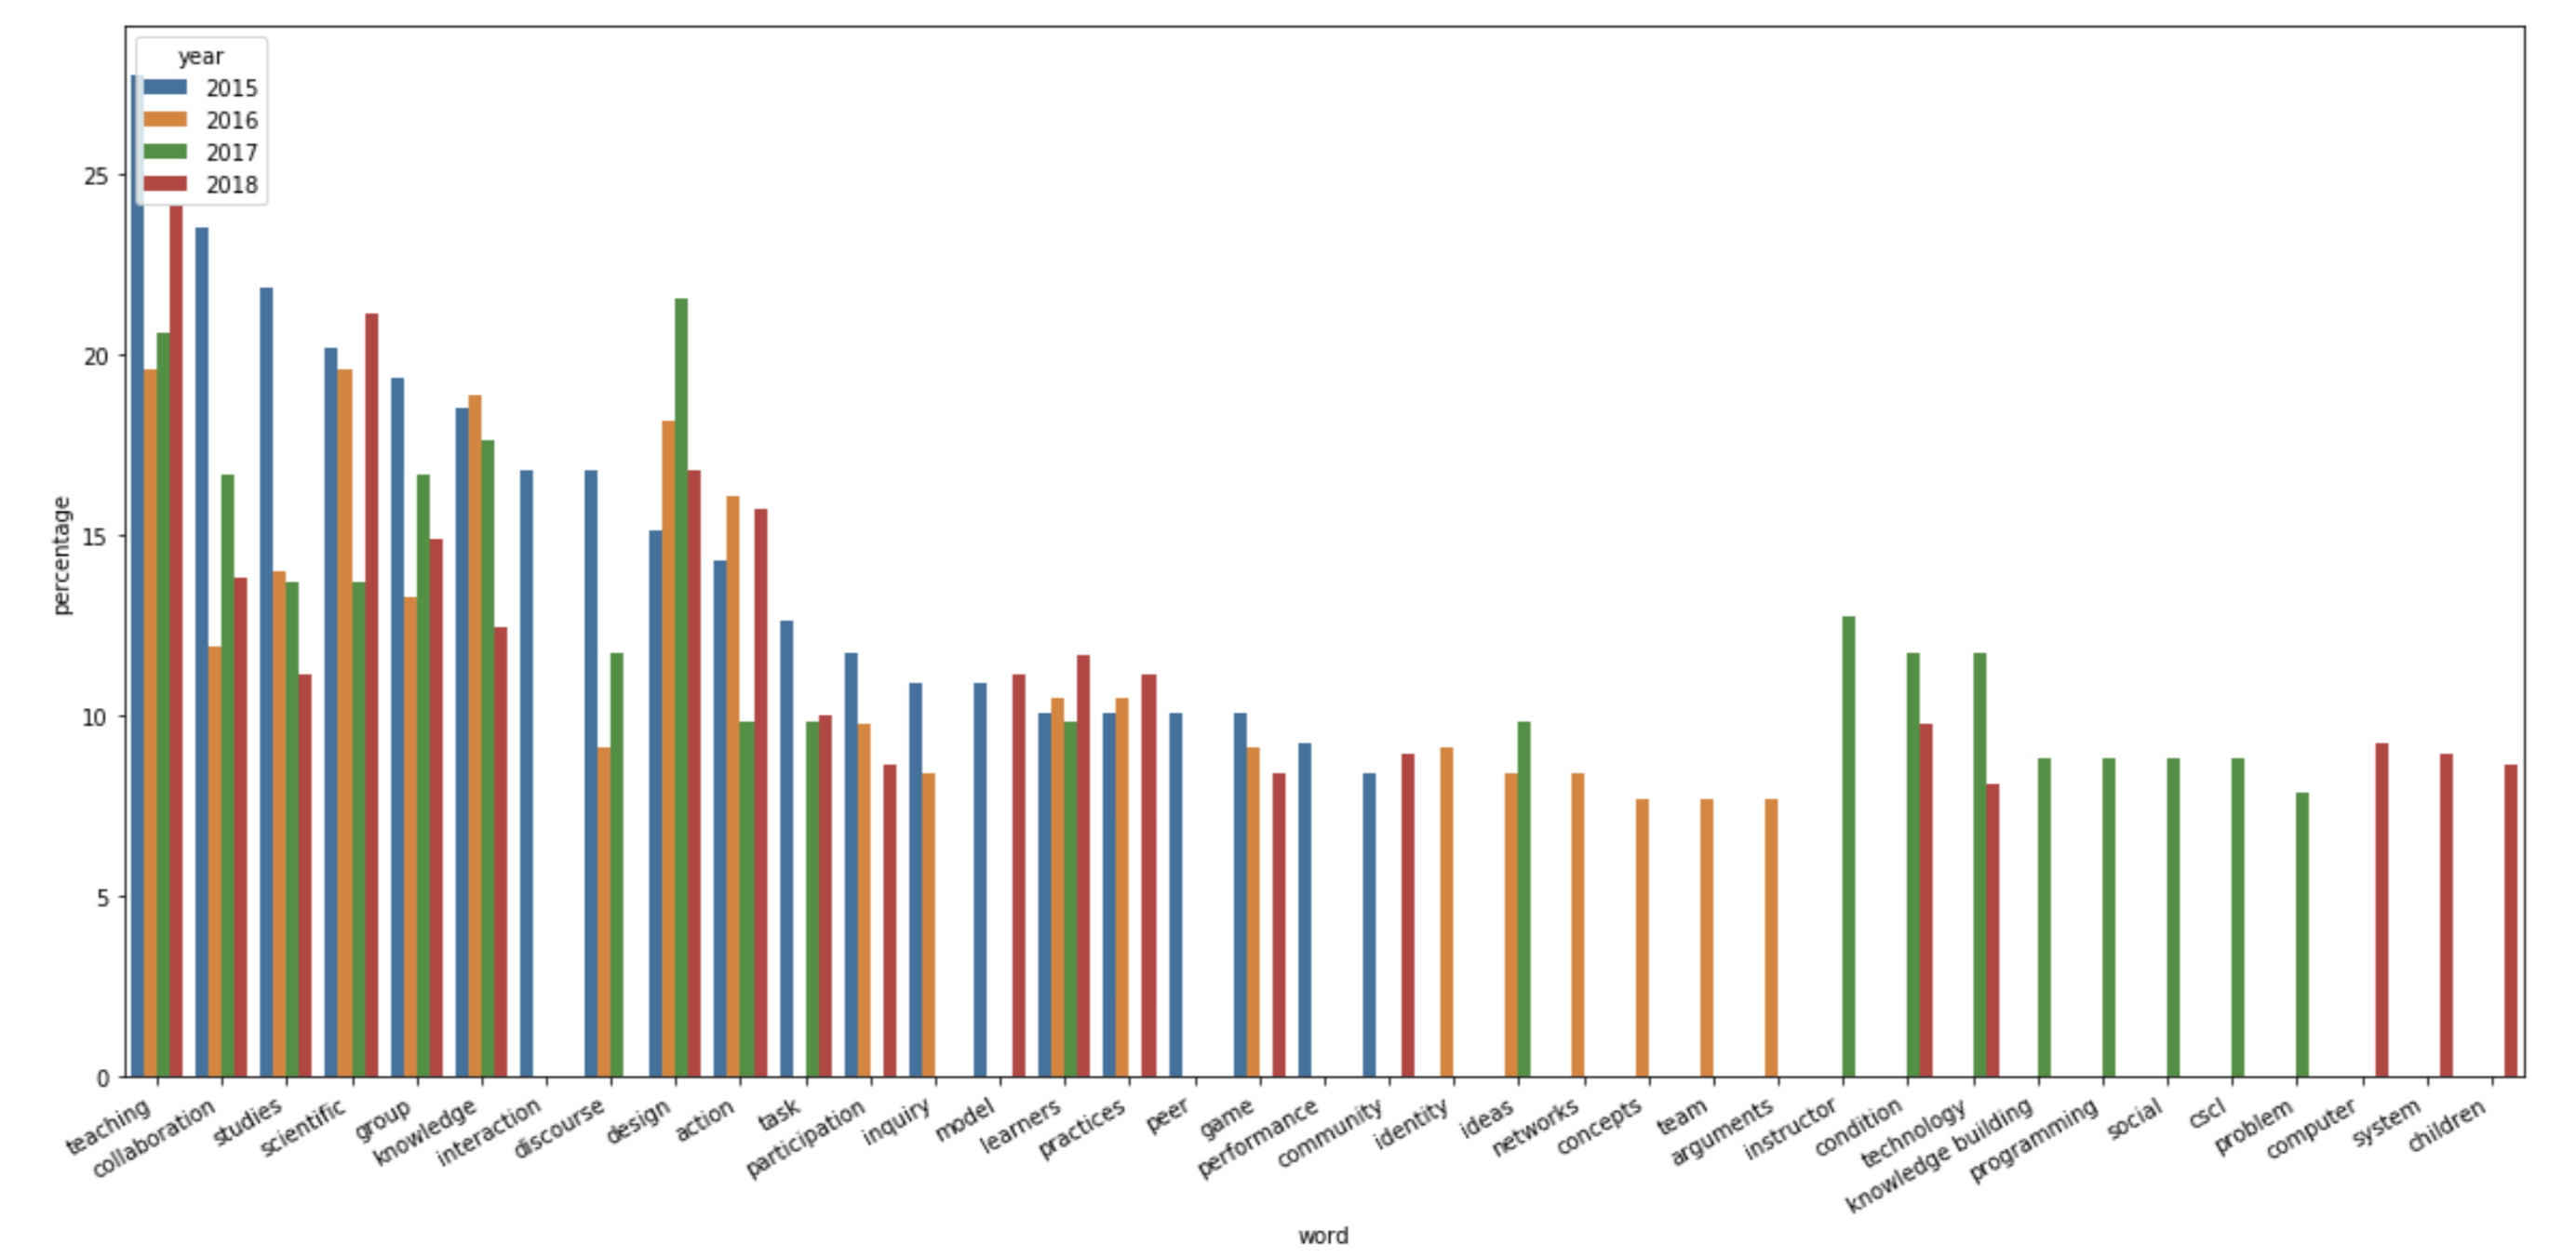

In [33]:
from IPython.display import Image
Image("keywords_by_year.png")

We wanted then to know what are the trends of words for each specific year, so we selected distinct words for each year, it means that we selected for each year the words that were present for that year and never for the others.
We get the graph below. 
As we can see from the graph, the most used word in the papers, more than 10% of 2015 papers uses the word 'peer', more than 6% of the papers uses the words 'building', 'embodied' in 2016. In 2017 the most frequent keyword on is 'reponsive' and in 2018 'tools' is present with more than 6%.  

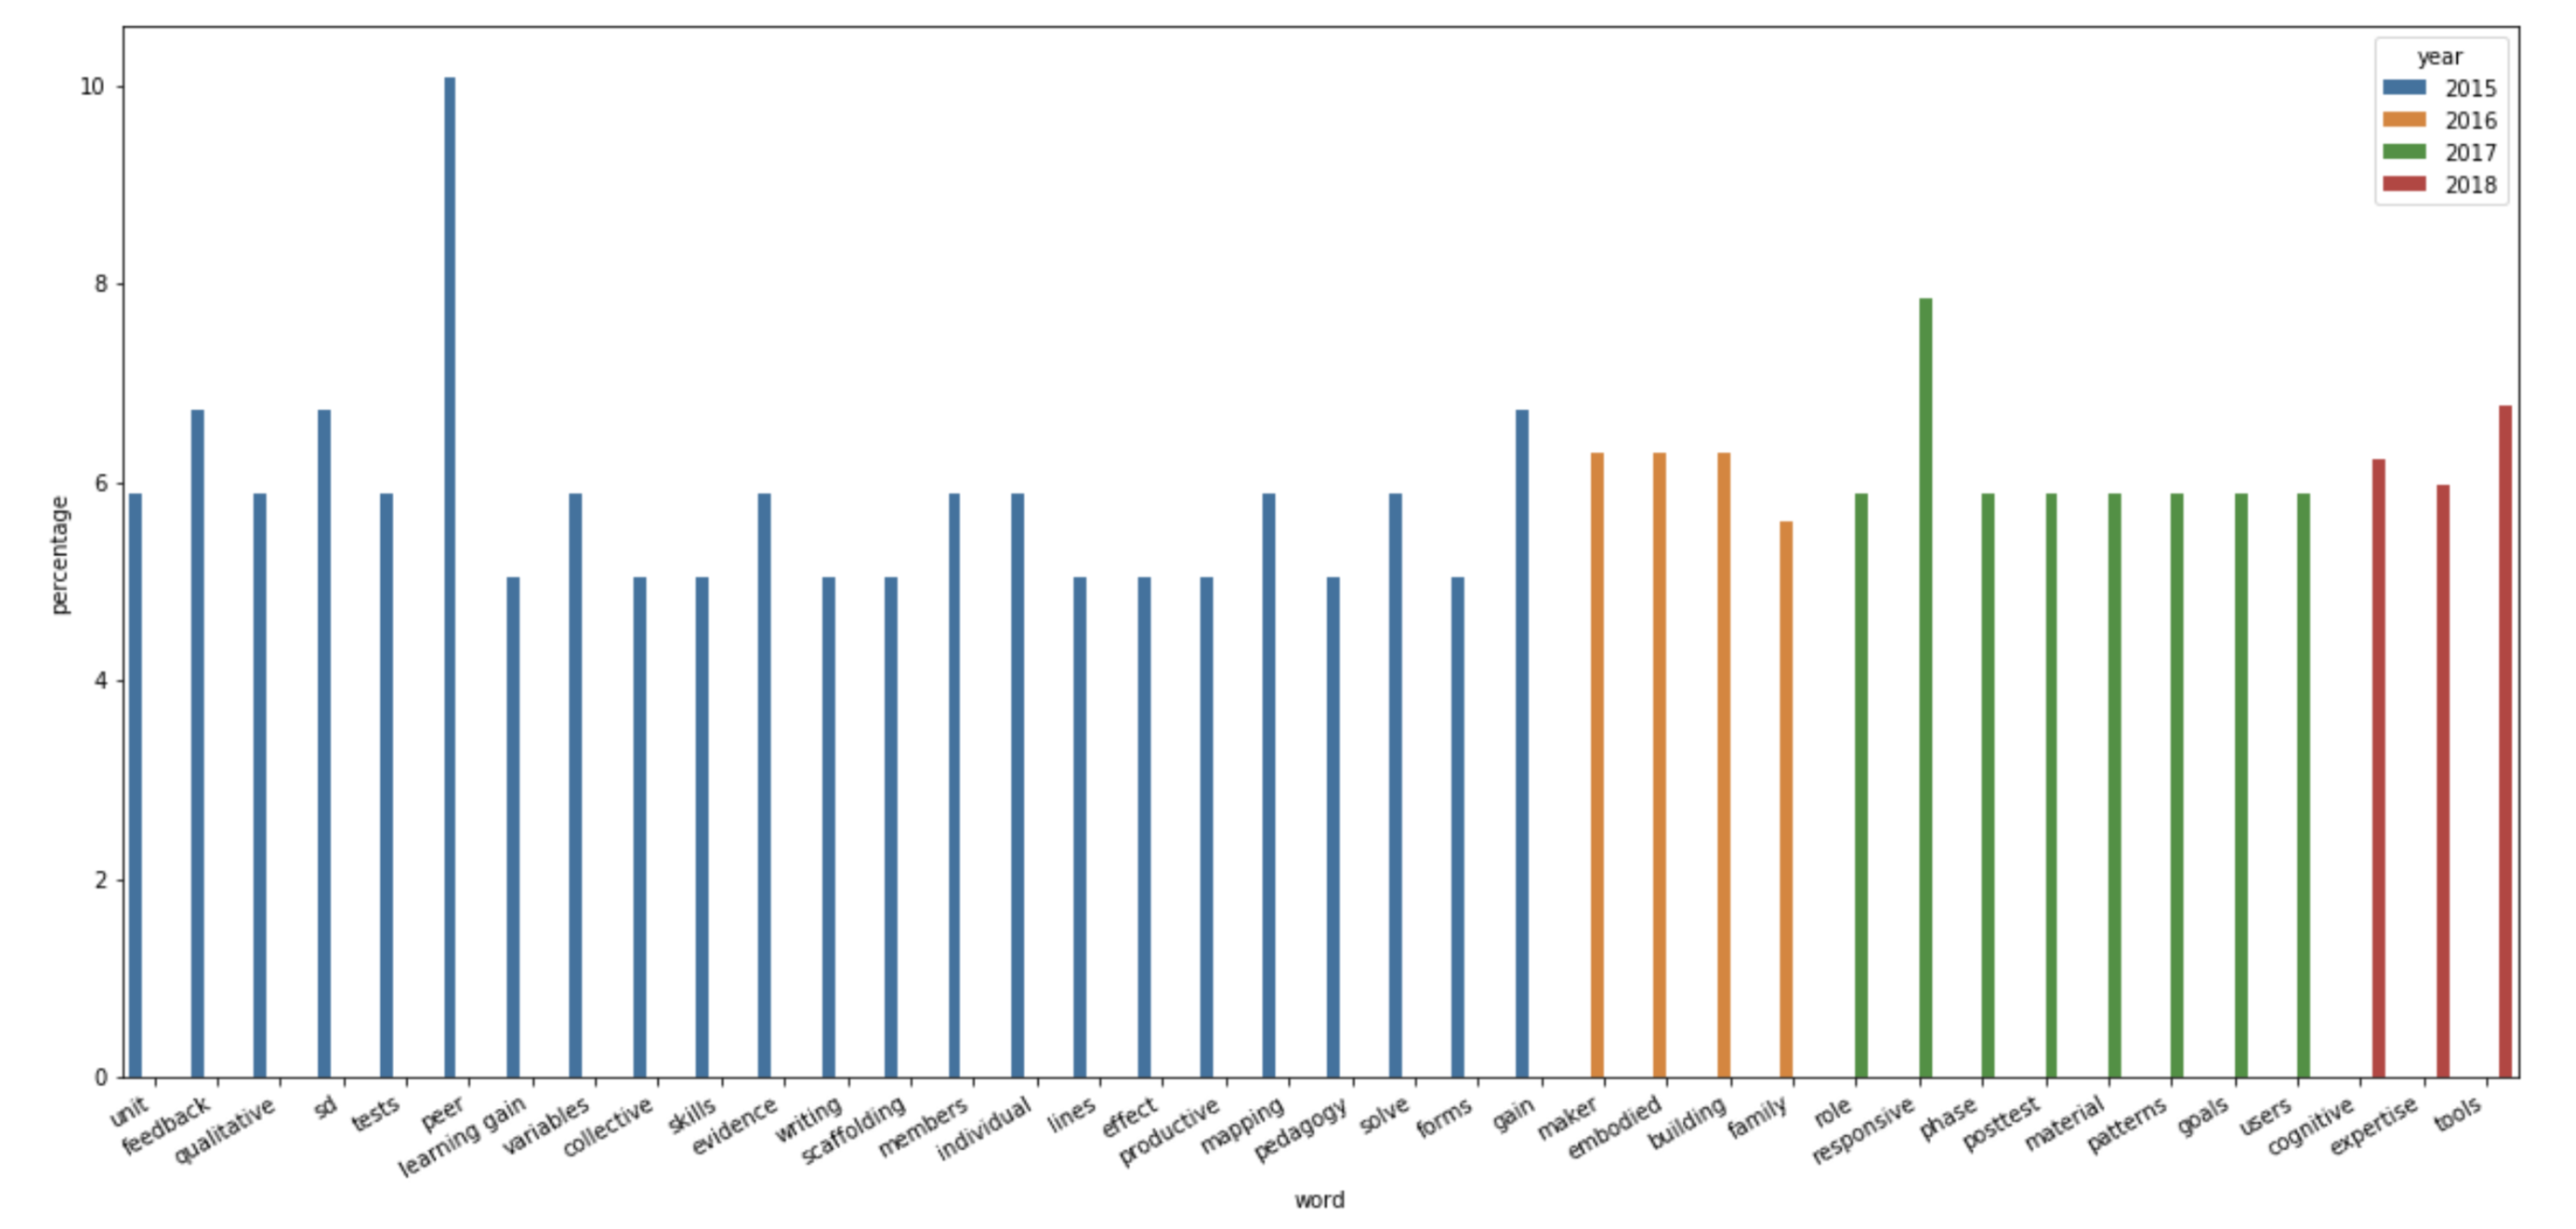

In [37]:
Image("distinct_words.png")


## Document Clustering 